# 電影評論
* data = https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data  
submmit: https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/submit  
* step
### 1. [準備原始文本數據](#preprocessing)
### 2. [BERT格式](#bertmode)
### 3. [下游任務模型](#finetune)
### 4. [訓練模型](#model)
### 5. [新樣本預測](#predict)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import os
import torch
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertForSequenceClassification

<a id = preprocessing></a>
### 準備原始文本數據

In [2]:
train = pd.read_csv('/home/bettyliao/sentiment/data/kaggle_movie_reviews/train.tsv', sep = '\t') 
test_ = pd.read_csv('/home/bettyliao/sentiment/data/kaggle_movie_reviews/test.tsv', sep = '\t')
print(f"""train: {train.columns.values}\ntest: {test_.columns.values}\n""") 
print(f"""train info: {train.info()}\ntest info:{test_.info()}""")

train: ['PhraseId' 'SentenceId' 'Phrase' 'Sentiment']
test: ['PhraseId' 'SentenceId' 'Phrase']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int64 
 1   SentenceId  66292 non-null  int64 
 2   Phrase      66292 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
train info: None
test info:None


In [3]:
train = train[['Phrase', 'Sentiment']]
test = test_[['Phrase']]
display(train.head(), test.head())

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2


,Phrase
0,An intermittently pleasing but mostly routine ...
1,An intermittently pleasing but mostly routine ...
2,An
3,intermittently pleasing but mostly routine effort
4,intermittently pleasing but mostly routine


In [4]:
train['Phrase'] = train['Phrase'].str.replace('\.', '[SEP]')

test['Phrase'] = test['Phrase'].str.replace('\.', '[SEP]')

/home/bettyliao/sentiment/sentiment/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


each catrgory ratio: 
 2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64


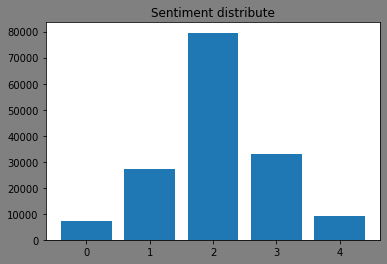

In [5]:
sent_count = train.groupby(['Sentiment']).size().to_frame('count').reset_index() 
plt.figure(facecolor = 'grey')
plt.bar(sent_count['Sentiment'], sent_count['count'])
plt.title('Sentiment distribute')
print('each catrgory ratio: \n',train['Sentiment'].value_counts()/ len(train))

In [6]:
train_ = train.sample(frac = 0.01, random_state = 123).reset_index().drop(['index'], axis = 1)
train_.to_csv('/home/bettyliao/sentiment/data/kaggle_movie_reviews/train1.tsv', sep = '\t', index = False)
test.to_csv('/home/bettyliao/sentiment/data/kaggle_movie_reviews/test1.tsv', sep = '\t', index = False) 

<a id = bertmode></a>
### ● BERT格式

In [7]:
PRETRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME) 
vocab = tokenizer.vocab # 28996

In [8]:
class SentiDataset(Dataset):
    os.chdir('/home/bettyliao/sentiment/data/kaggle_movie_reviews')
    def __init__(self, mode, tokenizer):
        assert mode in ['train1', 'test1']
        self.mode = mode
        self.df = pd.read_csv(mode + '.tsv', sep = '\t').fillna('') 
        self.len = len(self.df)
        self.tokenizer = tokenizer
    def __getitem__(self, idx):
        if self.mode == 'test1':
            text_a = self.df.Phrase.iloc[idx]
            text_b = ''
            label_tensor = None
        else:
            text_a = self.df.Phrase.iloc[idx]
            text_b = ''
            label_tensor = torch.tensor(self.df.Sentiment.iloc[idx]) 
        # text_a
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a
        len_a = len(word_pieces)
        
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces) 
        tokens_tensor = torch.tensor(ids)
        segments_tensor = torch.tensor([0] * len_a, dtype = torch.long) 
        
        return (tokens_tensor, segments_tensor, label_tensor)
    def __len__(self):
        return self.len

In [9]:
trainset = SentiDataset('train1', tokenizer = tokenizer)

In [10]:
sample_idx = 0
text_a, label = trainset.df.iloc[sample_idx].values  
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx] 
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist()) 
combined_text = ' '.join(tokens)

print(f"""
[origin]
sentence_a = {text_a}
label = {label}
---------------------------
[tensors]
tokens_tensor: {tokens_tensor}
segments_tensor: {segments_tensor}
label_tensor: {label_tensor}
[text]
{combined_text}
""")


[origin]
sentence_a = Ken
label = 2
---------------------------
[tensors]
tokens_tensor: tensor([ 101, 5928])
segments_tensor: tensor([0, 0])
label_tensor: 2
[text]
[CLS] Ken



In [11]:
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples]) 
    else:
        label_ids = None
    tokens_tensors = pad_sequence(tokens_tensors, batch_first = True) 
    segments_tensors = pad_sequence(segments_tensors, batch_first = True) 
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype = torch.long) 
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)  
    return tokens_tensors, segments_tensors, masks_tensors, label_ids
batch_size = 64
trainloader =  DataLoader(trainset, batch_size = batch_size, collate_fn = create_mini_batch)

In [12]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, masks_tensors, label_ids = data  

# tokens_tensors, segments_tensors, masks_tensors因長度不同需padding  
print(f"""
tokens_tensors: {tokens_tensors.shape}
{tokens_tensors}
-------------------------------------
segments_tensors: {segments_tensors.shape}
{segments_tensors}
------------------------------------------
masks_tensors: {masks_tensors.shape}
{masks_tensors}
------------------------------------
label_ids.shape = {label_ids.shape}
{label_ids}
""")


tokens_tensors: torch.Size([64, 44])
tensor([[ 101, 5928,    0,  ...,    0,    0,    0],
        [ 101, 1103, 1692,  ...,    0,    0,    0],
        [ 101, 1106, 1321,  ...,    0,    0,    0],
        ...,
        [ 101, 1110, 1126,  ...,    0,    0,    0],
        [ 101,  117, 1122,  ...,    0,    0,    0],
        [ 101, 1110, 1120,  ...,    0,    0,    0]])
-------------------------------------
segments_tensors: torch.Size([64, 44])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------------------------
masks_tensors: torch.Size([64, 44])
tensor([[1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------------------------------------
label_i

 <a id = finetune></a>
### ●下游任務模型

In [13]:
PRETRAINED_MODEL_NAME = 'bert-base-cased'
NUM_LABELS = 5
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels = NUM_LABELS) 
clear_output()

print("""
name     module
-------------------""")
for name, module in model.named_children():
    if name == 'bert':
        for n, _ in module.named_children():
            print(f'{name} : {n}')
    else:
        print('{:15}{}'.format(name, module))


name     module
-------------------
bert : embeddings
bert : encoder
bert : pooler
dropout        Dropout(p=0.1, inplace=False)
classifier     Linear(in_features=768, out_features=5, bias=True)


<a id = model></a>
### ● 訓練模型

In [14]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions
    
# 讓模型跑在 GPU 上並取得訓練集的分類準確率
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
_, acc = get_predictions(model, trainloader, compute_acc=True)
print("初始 classification acc:", round(acc * 100, 2))

device: cpu
初始 classification acc: 17.49


In [15]:
def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad] 

model_params = get_learnable_params(model)
clf_params = get_learnable_params(model.classifier)

print(f'''
整體模型參數： {sum(p.numel() for p in model_params)}
線性模型參數: {sum(p.numel() for p in clf_params)}
''')


整體模型參數： 108314117
線性模型參數: 3845



In [16]:
%%time
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5) 
EPOCHS = 6  #
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for data_ in trainloader:
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data_]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids = tokens_tensors, 
                        token_type_ids = segments_tensors, 
                        attention_mask = masks_tensors, 
                        labels = labels)

        loss = outputs[0]
        # backward
        loss.backward()
        optimizer.step()


        # 紀錄當前 batch loss
        running_loss += loss.item()
        
    # 計算分類準確率
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))

[epoch 1] loss: 37.236, acc: 0.502
[epoch 2] loss: 31.860, acc: 0.511
[epoch 3] loss: 29.769, acc: 0.552
[epoch 4] loss: 26.816, acc: 0.626
[epoch 5] loss: 23.459, acc: 0.683
[epoch 6] loss: 20.695, acc: 0.744
CPU times: user 2h 26min 1s, sys: 13.4 s, total: 2h 26min 14s
Wall time: 24min 59s


<a id = predict></a>
### ● 新樣本預測

In [17]:
%%time
testset = SentiDataset('test1', tokenizer = tokenizer)
testloader = DataLoader(testset, batch_size = 256, collate_fn = create_mini_batch) 

CPU times: user 34.8 ms, sys: 7.98 ms, total: 42.8 ms
Wall time: 42 ms


In [18]:
predictions = get_predictions(model, testloader)

In [19]:
df = pd.DataFrame({'Sentiment': predictions.tolist()})

In [20]:
final = pd.concat([test_['PhraseId'], df], axis = 1)
final.Sentiment = final.Sentiment.astype('str')
final.Sentiment = final.Sentiment.str.replace('.0', '')

In [21]:
final.head()

,PhraseId,Sentiment
0,156061,3
1,156062,3
2,156063,2
3,156064,2
4,156065,3


In [22]:
final.to_csv('/home/bettyliao/sentiment/output/bert_result1.csv', index = False) 

In [23]:
model.config

BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "transformers_version": "4.16.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

參考資料：  
https://medium.com/programming-with-data/32-transformer-%E9%A0%90%E8%A8%93%E7%B7%B4-%E9%9B%86%E5%A4%A7%E6%88%90%E7%9A%84-bert-%E6%A8%A1%E5%9E%8B-c928530f6db8